In [6]:
import glob

from astropy.io import fits
from deeplenstronomy import deeplenstronomy as dl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%writefile test_bg_cal.yaml
DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 10
        OUTDIR: BackgroundCalibration
        SEED: 6

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

IMAGE:
    PARAMETERS:
        exposure_time: 90
        numPix: 100
        pixel_scale: 0.263
        psf_type: 'GAUSSIAN'
        read_noise: 7
        ccd_gain: 6.083

SURVEY:
    PARAMETERS:
        BANDS: g,r,i,z
        seeing: 0.9
        magnitude_zero_point: 30.0
        sky_brightness: 23.5
        num_exposures: 8

SPECIES:
    GALAXY_1:
        NAME: LENS
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 20.0
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        MASS_PROFILE_1:
            NAME: SIE 
            PARAMETERS:
                theta_E: 1.1
                e1: 0.1
                e2: -0.1
                center_x: 0.0
                center_y: 0.0
    GALAXY_2:
        NAME: DARK_GALAXY
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 100.0
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        MASS_PROFILE_1:
            NAME: SIE 
            PARAMETERS:
                theta_E: 1.1
                e1: 0.1
                e2: -0.1
                center_x: 0.0
                center_y: 0.0
         
    POINTSOURCE_1:
        NAME: STAR
        HOST: DARK_GALAXY
        PARAMETERS:
            magnitude: 20.0

GEOMETRY:
    CONFIGURATION_1:
        NAME: Galaxy
        FRACTION: 0.5
        PLANE_1:
            OBJECT_1: LENS
            PARAMETERS:
                REDSHIFT: 0.2            
        PLANE_2:
            OBJECT_1: DARK_GALAXY
            PARAMETERS:
                REDSHIFT: 0.5
              
    CONFIGURATION_2:
        NAME: Star
        FRACTION: 0.5
        PLANE_1:
            OBJECT_1: DARK_GALAXY
            OBJECT_2: STAR
            PARAMETERS:
                REDSHIFT: 0.2    
        PLANE_2:
            OBJECT_1: DARK_GALAXY
            PARAMETERS:
                REDSHIFT: 0.5


Writing test_bg_cal.yaml


In [3]:
dataset = dl.make_dataset('test_bg_cal.yaml', verbose=True)

Entering main organization loop
Organizing CONFIGURATION_1
Organizing CONFIGURATION_2
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 0 S         
Generating images for CONFIGURATION_2
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 0 S         


i band mag 20 galaxies

```
DESSCI ~> select RA, DEC from y3_gold_2_2 where mag_auto_i between 19.999 and 20.001 and EXTENDED_CLASS_COADD = 3 and ROWNUM <= 5;
```

```
          RA        DEC
1  35.364347 -61.456593
2  33.796208 -62.211660
3  30.270475 -43.254656
4  33.054012 -43.102470
5  35.408451 -64.422924
```

i band mag 20 stars

```
DESSCI ~> select RA, DEC from y3_gold_2_2 where mag_psf_i between 19.999 and 20.001 and EXTENDED_CLASS_COADD = 0 and ROWNUM <= 5;

           RA        DEC
1  327.098173 -65.112821
2  324.465129 -56.393361
3  316.102436 -46.738196
4  320.071929 -57.211821
5  326.738338 -64.671998
```

In [5]:
gals_files = glob.glob("calibration_galaxies/*/*/*.fits")
star_files = glob.glob("calibration_stars/*/*/*.fits")

In [7]:
gals_ims = []
for file in gals_files:
    hdu = fits.open(file)
    gals_ims.append(hdu["SCI"].data)
    hdu.close()
    
star_ims = []
for file in star_files:
    hdu = fits.open(file)
    star_ims.append(hdu["SCI"].data)
    hdu.close()

In [8]:
def trim(arr):
    """
    Set the pixel values in the 99.9th percentile to the median value
    """
    med = np.median(arr)
    cut = np.percentile(arr, 99.9)
    return np.where(arr > cut, med, arr)
    
def crop_center(img,cropx,cropy):
    """
    Crop the image to the center
    """
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def process(img, cropx=10, cropy=10):
    """
    Crop edges and trim large values
    """
    arr = crop_center(img,cropx,cropy)
    return trim(arr)

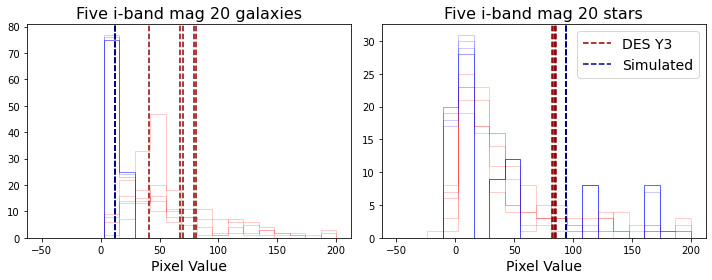

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

BINS=np.linspace(-50, 200, 20)
hist_kwargs = {'alpha':0.2, 'bins': BINS, 'histtype': 'step'}

for idx, im in enumerate(gals_ims):
    axs[0].hist(process(im).flatten(), color='red', **hist_kwargs)
    axs[0].axvline(np.sum(process(im).flatten() / 100), color='darkred', ls='--')
for idx, im in enumerate(dataset.CONFIGURATION_1_images):
    axs[0].hist(process(im[2,:,:]).flatten(), color='blue', **hist_kwargs)
    axs[0].axvline(np.sum(process(im[2,:,:]).flatten() / 100), color='darkblue', ls='--')
axs[0].set_title("Five i-band mag 20 galaxies", fontsize=16)
    
for idx, im in enumerate(star_ims):
    axs[1].hist(
        process(im).flatten(), color='red', **hist_kwargs)
    axs[1].axvline(
        np.sum(process(im).flatten()) / 100, color='darkred', ls='--',
        label = "DES Y3" if idx == 0 else None)
for idx, im in enumerate(dataset.CONFIGURATION_2_images):
    axs[1].hist(
        process(im[2,:,:]).flatten(), color='blue', **hist_kwargs)
    axs[1].axvline(
        np.sum(process(im[2,:,:]).flatten()) / 100, color='darkblue', ls='--',
        label = "Simulated" if idx == 0 else None)

        
axs[1].set_title("Five i-band mag 20 stars", fontsize=16)

axs[0].set_xlabel("Pixel Value", fontsize=14)
axs[1].set_xlabel("Pixel Value", fontsize=14)

axs[1].legend(fontsize=14)


    
fig.tight_layout()
plt.show()
plt.close()

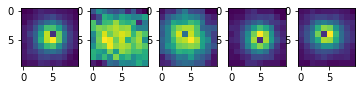

In [10]:
# Plot Real galaxy images
fig, axs = plt.subplots(1, 5)
for i in range(len(gals_ims)):
    axs[i].imshow(process(gals_ims[i]))

plt.show()
plt.close()